In [50]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
mat_contents = sio.loadmat('EEG_big.mat') # (EEG_data.mat')
# mat_contents = sio.loadmat('EEG_big4CNN_1subj.mat')

X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
# y_test = np.expand_dims(y_test,1)
# y_test = y_test[:,:,:,None]
# y_train = np.expand_dims(y_train,1)
# y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')

len = Y.shape[1]

print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (109, 60, 800, 1) Nomralized MEAN: 0.51855 min 0.0 max 1.0
train input shape (434, 60, 800, 1) Nomralized MEAN: 0.51709 min 0.0 max 1.0
test labels shape (109, 800) Nomralized MEAN: 0.49756 min 0.0 max 1.0
train labels shape (434, 800) Nomralized MEAN: 0.48926 min 0.0 max 1.0


In [51]:
# we first define the autoencoder's architecture:

# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.initializers import Orthogonal as orth

import numpy as np
import matplotlib.pyplot as plt

def conv_net():
    input_img = Input(shape=(60, len, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(4, (3, 3), activation='relu', padding='same',                
                            kernel_initializer = orth(gain=1.0, seed=None))(input_img)
    e2 = MaxPooling2D((2, 1), padding='same')(e1)
    e2b = BatchNormalization(axis=1)(e2)
    e2a = Dropout(0.2)(e2b)
    e3 = Conv2D(8, (3, 3), activation='relu', padding='same',
                            kernel_initializer = orth(gain=1.0, seed=None))(e2a)
    e4 = MaxPooling2D((3, 1), padding='same')(e3)
    e4b = BatchNormalization(axis=1)(e4)
    e4a = Dropout(0.3)(e4b)
    e5 = Conv2D(16, (3, 3), activation='relu', padding='same',
                            kernel_initializer = orth(gain=1.0, seed=None))(e4a)
    e6 = MaxPooling2D((2, 1), padding='same')(e5)
    e6b = BatchNormalization(axis=1)(e6)
    e6a = Dropout(0.4)(e6b)
    e7 = Conv2D(32, (3, 3), activation='relu', padding='same', 
                            kernel_initializer = orth(gain=1.0, seed=None))(e6a)
    e8 = MaxPooling2D((5, 1), padding='same')(e7)
    e9 = Dropout(0.5)(e8)
    e9b = Conv2D(32, (3, 3), activation='relu', padding='same', 
                            kernel_initializer = orth(gain=1.0, seed=None))(e9)
    e10 = Flatten()(e9b)
    e11 = Dense(len*2, activation='relu',                
                            kernel_initializer = orth(gain=1.0, seed=None))(e10)
    e12 = Dropout(0.6)(e11)
    e12b = BatchNormalization(axis=1)(e12)
    e13 = Dense(len, activation='sigmoid',                
                            kernel_initializer = orth(gain=1.0, seed=None))(e12b)
    return Model(input_img, e13)

In [52]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

In [53]:
# define input to the model:
x = Input(shape=(60, len, 1))

# make the model:
model = conv_net()

# compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
# model.compile(optimizer='rmsprop', loss=correlation_coefficient_loss)

In [54]:
# SEE INSIDE THE MODEL:
# conv_net().summary() #or
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 60, 800, 1)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 60, 800, 4)        40        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 800, 4)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 30, 800, 4)        120       
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 800, 4)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 30, 800, 8)        296       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 800, 8)        0         
__________

Text(0.5,1,'Channels 11 in test samples 6 and 16')

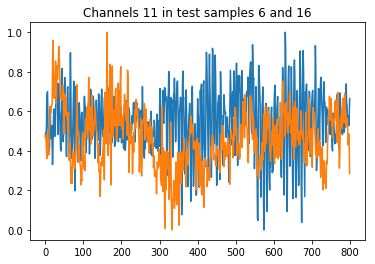

In [55]:
# inspect channel ___ sample
chan = 30
samp = 12
%matplotlib inline
plt.plot(range(0, len), x_test[samp, chan,:,0], range(0,len), y_test[samp,:])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

In [56]:
# Training time!
# Try 20 epochs using batch size = 3, then switch to 4
early_stopping = EarlyStopping(monitor='val_loss', patience=40)

model.fit(x_train, y_train,
                epochs=1000,
                batch_size=40,
                shuffle=True,
#                 validation_split=0.2,
                validation_data=(x_test, y_test),
                  callbacks=[TensorBoard(log_dir='/home/amplifier/home/CNN_stim'), early_stopping])

# save the entire model and the weights after the training:
model.save('/home/amplifier/home/models/EEGnet.h5')
model.save_weights('/home/amplifier/home/weights/EEGnet_weights.h5')

Train on 434 samples, validate on 109 samples
Epoch 1/1000
434/434 [==============================] - 3s 6ms/step - loss: 0.7442 - val_loss: 0.6986
Epoch 2/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.7279 - val_loss: 0.7031
Epoch 3/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.7194 - val_loss: 0.6981
Epoch 4/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.7104 - val_loss: 3.8675
Epoch 5/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.7033 - val_loss: 0.7004
Epoch 6/1000
434/434 [==============================] - 2s 3ms/step - loss: 0.6985 - val_loss: 0.7015
Epoch 7/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.6949 - val_loss: 0.7025
Epoch 8/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.6927 - val_loss: 0.6991
Epoch 9/1000
434/434 [==============================] - 1s 3ms/step - loss: 0.6905 - val_loss: 0.6992
Epoch 10/1000
434/434 [=============

In [37]:
# let's predict a TRAINING sammple:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(624, 400)
(156, 400)


Pearson's R: [ 0.17600824] p-value [ 0.00040501]


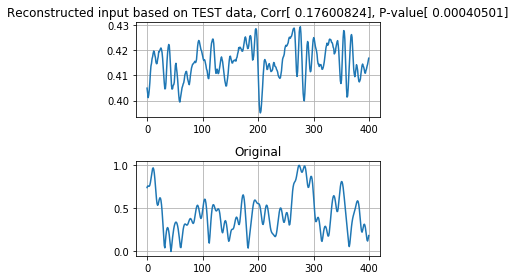

In [41]:
reconstruct_training_sample = False
samp = 1

from scipy.stats import pearsonr
# now let's see how the model performs:

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,:].reshape(len,1)
    orig = y_train[samp,:].reshape(len,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data, " + "Corr"+ str(R) + ", P-value" + str(p)
else:
    reconst = decoded_test[samp,:].reshape(len,1)
    orig = y_test[samp,:].reshape(len,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TEST data, " + "Corr"+ str(R) + ", P-value" + str(p)


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.grid()
ax.set_title(title)
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
ax.set_title("Original")
ax.grid()
plt.tight_layout()

In [ ]:
R,p = pearsonr(reconst, orig)

In [ ]:
print(R)